# Tanzanian Water Point Predictions

## Introduction

According to water.org, of the 59 million people in Tanzania, 16 million of them or 28% of the population do not have easy access to clean water. By looking at data provided by Taarifa and the Tanzanian Ministry of Water, we can see what is working and what is not working to predict whether a given water point will be functional or if it will need repair based on several factors. With this information, we can decide how and where to establish new water points.

The intended stakeholders are a board of directors for an NGO that is looking for help in figuring out where and how to help with the water crisis in Tanzania. 

The goal is to build a classifier in order to make a prediction of the operating condition of a water point in Tanzania for each record in the dataset.

The implications of this project could mean several people having access to clean water.

In [668]:
#imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, plot_roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Import The Data

In [669]:
values = pd.read_csv('./Data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv')

In [670]:
labels = pd.read_csv('./Data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv')

In [671]:
values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [672]:
labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [673]:
values.tail()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
59399,26348,0.0,2011-03-23,World Bank,191,World,38.104048,-6.747464,Kwa Mzee Lugawa,0,...,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump


In [674]:
labels.tail()

,id,status_group
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional
59399,26348,functional


In [675]:
values.shape

(59400, 40)

In [676]:
labels.shape

(59400, 2)

In [677]:
values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [678]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


### Merge the data sets

It looks like the "id" in both datasets follow the same order. And there is the same number of rows. I'm going to join them together to have one dataset to work with.

In [679]:
df = values.merge(labels, on='id')
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## Clean The Data

### Handling Missing Values

I'm going to see if there are any missing values and handle them appropriately.

In [680]:
df.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

I don't want to impute subvillage. I'd rather change the missing values to 'none'. And I don't want to deal with scheme_name because there are too many missing values. I feel fine imputing the other columns with missing data.

Before I get carried away, I'm going to make a copy of the data.

In [681]:
# create a copy
df_copy = df.copy()

In [682]:
# fill the nulls with "Unknown" or "None"
df_copy.fillna({'scheme_name': 'none',
                    'subvillage': 'none'},
                   inplace=True)

In [683]:
df_copy.isna().sum()

id                          0
amount_tsh                  0
date_recorded               0
funder                   3635
gps_height                  0
installer                3655
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                  0
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3334
recorded_by                 0
scheme_management        3877
scheme_name                 0
permit                   3056
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity  

### Change Cases

In [684]:
df_copy.funder = df_copy.funder.str.lower()
df_copy.installer = df_copy.installer.str.lower()
df_copy.scheme_management = df_copy.scheme_management.str.lower()
df_copy.scheme_name = df_copy.scheme_name.str.lower()

### Identify Relevant Columns

In [685]:
df_copy.amount_tsh.describe()

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

It looks like these numbers are widely varied, with a majority of them as "0" and the max as "350,000". Having a total static head of 350,000 meters seems very unrealistic when you consider Mt Everest is almost 9,000 meters. I don't want to use this column becaue I don't think the data is reliable.

With a little research, I found that there are many districts within a region. That tells me that I should use the region code instead of the district code because the same district code could be used in different regions causing duplicates.

The columns I'm interested in are:
* gps_height
* installer
* basin
* region_code
* population
* public_meeting
* scheme_management
* permit
* construction_year
* extraction_type_class
* management_group
* payment_type
* quality_group
* source_type
* waterpoint_type
* status_group

Which means the columns I'm NOT interested in are:
* id
* amount_tsh
* date_recorded
* funder
* longitude
* latitude
* wpt_name
* num_private
* subvillage
* region
* district_code
* ward
* lga
* recorded_by
* scheme_name
* extraction_type
* extraction_type_group
* management
* payment
* water_quality
* quantity
* source
* source_class
* waterpoint_type_group

### Data Preparation

#### Prepare Target Column

In [686]:
labels.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [687]:
# making this binary
df_copy.status_group = df_copy.status_group.str.replace('functional needs repair', 'non functional')
df_copy.status_group.value_counts()

functional        32259
non functional    27141
Name: status_group, dtype: int64

In [690]:
# instantiate a label encoder for the target, and define variables.

X = df_copy[['gps_height', 'installer', 'basin', 'region_code', 'population', 'public_meeting',
             'scheme_management', 'permit', 'construction_year', 'extraction_type_class', 'management_group',
             'payment_type', 'quality_group', 'source_type', 'waterpoint_type']]
y = df_copy.status_group

le = LabelEncoder()
y = pd.Series(le.fit_transform(y))

In [691]:
# test out the y
y.value_counts()

0    32259
1    27141
dtype: int64

0 = functional

1 = needs repair

In [692]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

#### Train Test Split

In [693]:
# for holdout data set
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(X, y, test_size=0.15, random_state=22)

In [694]:
# checking work
y_train_both.value_counts(normalize=True)

0    0.542999
1    0.457001
dtype: float64

In [695]:
y_test_both.value_counts(normalize=True)

0    0.543547
1    0.456453
dtype: float64

In [696]:
# another train_test_split for validation
X_train, X_test, y_train, y_test = train_test_split(X_train_both, y_train_both, test_size=0.15, random_state=22)

## Create Pipeline

In [697]:
# identify column types
numerics = X_train[['gps_height', 'population']].columns
categoricals = X_train.drop(columns=numerics).columns


# numeric subpipe
subpipe_numerics = Pipeline(steps = [
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])

# categorical subpipe
subpipe_cat = Pipeline(steps = [
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [698]:
CT = ColumnTransformer(transformers=[
    ('subpipe_numerics', subpipe_numerics, numerics),
    ('subpipe_cat', subpipe_cat, categoricals)
], remainder='passthrough')

## Dummy Model

In [699]:
dummy_model_pipe = Pipeline(steps = [
    ('ct', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [700]:
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'population'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(hand

### Results for Dummy Pipeline

<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

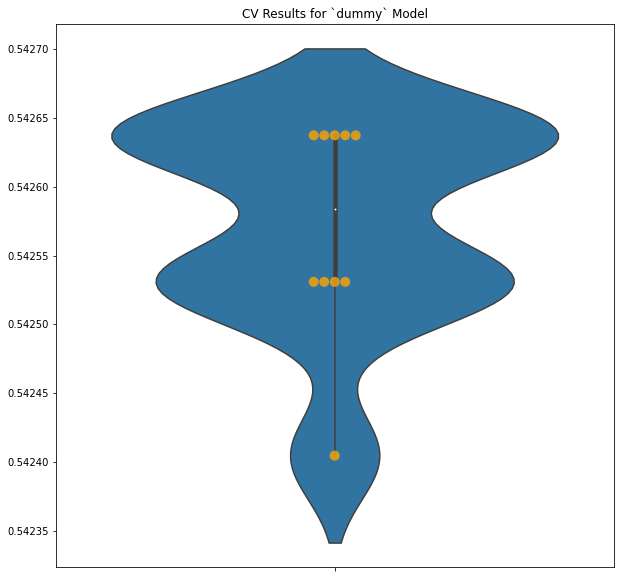

In [701]:
# Cross Validated on Training Data
dummy_model = ModelWithCV(
    dummy_model_pipe,
    model_name='dummy',
    X=X_train,
    y=y_train)
fig, ax = plt.subplots(figsize=(10,10))

dummy_model.plot_cv(ax=ax)

In [702]:
dummy_model.print_cv_summary()

CV Results for `dummy` model:
            0.54257 ± 0.00008 accuracy
        


In [703]:
dummy_model_pipe.score(X_test, y_test)

0.5454185371006074

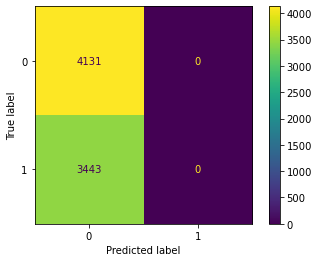

In [704]:
plot_confusion_matrix(dummy_model_pipe, X_test, y_test);

In [705]:
y_pred = dummy_model_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      4131
           1       0.00      0.00      0.00      3443

    accuracy                           0.55      7574
   macro avg       0.27      0.50      0.35      7574
weighted avg       0.30      0.55      0.38      7574



/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


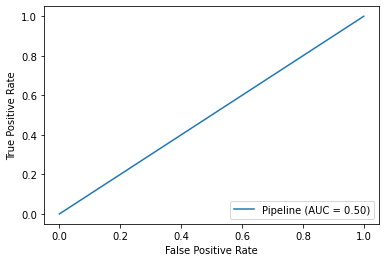

In [706]:
plot_roc_curve(dummy_model_pipe, X_test, y_test);

## Logistic Regression Model

In [707]:
# first simple model (fsm)
logreg_model_pipe = Pipeline(steps = [
    ('ct', CT),
    ('fsm', LogisticRegression(random_state=22))
])

In [708]:
logreg_model_pipe.fit(X_train, y_train)

/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'population'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(hand

### Results of First Simple Model (FSM)

/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

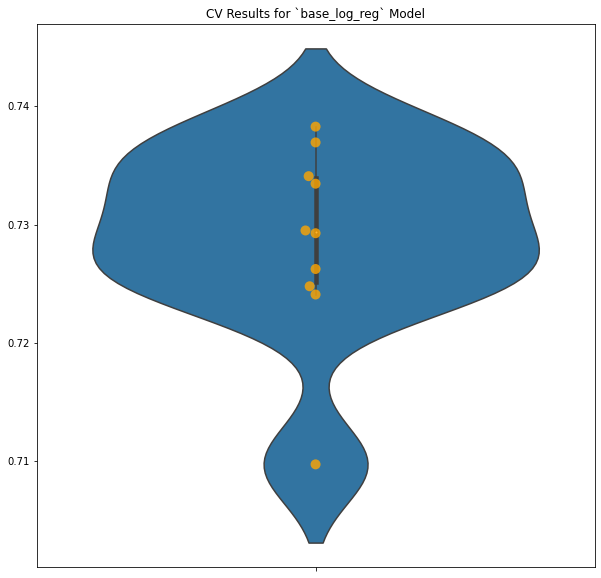

In [709]:
base_log_reg = ModelWithCV(
    logreg_model_pipe,
    model_name='base_log_reg',
    X=X_train,
    y=y_train)
fig, ax = plt.subplots(figsize=(10,10))

base_log_reg.plot_cv(ax=ax);

In [710]:
base_log_reg.print_cv_summary()

CV Results for `base_log_reg` model:
            0.72863 ± 0.00785 accuracy
        


In [711]:
logreg_model_pipe.score(X_test, y_test)

0.7302614206495907

In [712]:
y_pred = logreg_model_pipe.predict(X_test)

In [713]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77      4131
           1       0.75      0.61      0.67      3443

    accuracy                           0.73      7574
   macro avg       0.73      0.72      0.72      7574
weighted avg       0.73      0.73      0.73      7574



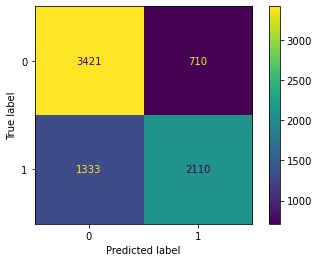

In [714]:
plot_confusion_matrix(logreg_model_pipe, X_test, y_test);

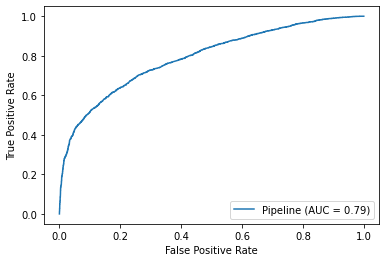

In [715]:
plot_roc_curve(logreg_model_pipe, X_test, y_test)

#### Description

This first model does better than our dummy model and it is not overfit. However, this warning is saying that it ran out of iterations, so I'd like to raise the max iteration limit on the logistic regression model.

### Adjustments to Logistic Regression Model

In [716]:
params = {}

params['fsm__max_iter'] = [1000]
params['fsm__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
params['fsm__C'] = [10.0, 1.0, 0.1]

gs = GridSearchCV(logreg_model_pipe, param_grid=params, cv=5)

In [717]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_numerics',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'population'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_imputer',
                   

In [718]:
gs.best_params_

{'fsm__C': 1.0, 'fsm__max_iter': 1000, 'fsm__solver': 'lbfgs'}

In [719]:
gs.best_score_

0.7303569910350756

In [720]:
gs.best_estimator_.score(X_test, y_test)

0.7302614206495907

#### Description

Looking at the best parameters for this model, the score is not significantly different than the original logistic regression model. Let's try another model out!

## Decision Tree Model

In [721]:
base_dtc_pipe = Pipeline(steps=[
    ('ct',CT),
    ('base_dtc', DecisionTreeClassifier(random_state=42))
])

In [722]:
base_dtc_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'population'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(hand

### Results of Decision Tree Model

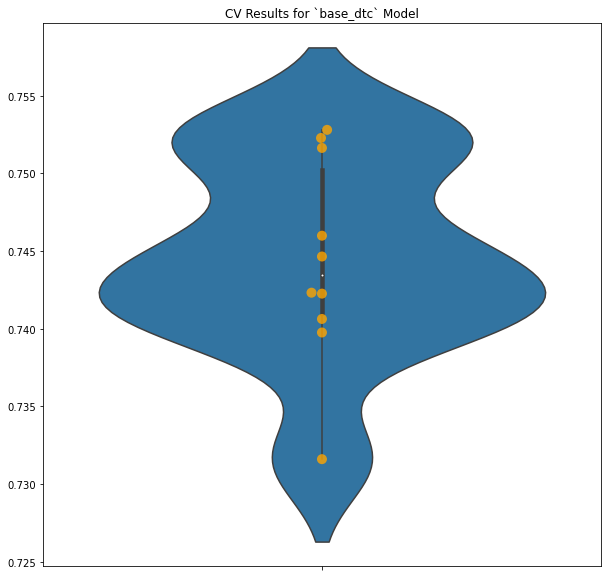

In [723]:
base_dtc = ModelWithCV(
    base_dtc_pipe,
    model_name='base_dtc',
    X=X_train,
    y=y_train)
fig, ax = plt.subplots(figsize=(10,10))

base_dtc.plot_cv(ax=ax);

In [724]:
base_dtc.print_cv_summary()

CV Results for `base_dtc` model:
            0.74438 ± 0.00629 accuracy
        


In [725]:
base_dtc_pipe.score(X_test, y_test)

0.7432004224980195

In [726]:
y_pred = base_dtc_pipe.predict(X_test)

In [727]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      4131
           1       0.73      0.69      0.71      3443

    accuracy                           0.74      7574
   macro avg       0.74      0.74      0.74      7574
weighted avg       0.74      0.74      0.74      7574



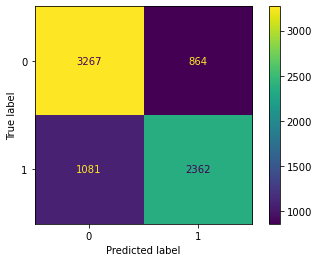

In [728]:
plot_confusion_matrix(base_dtc_pipe, X_test, y_test);

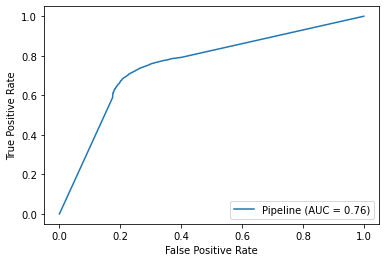

In [729]:
plot_roc_curve(base_dtc_pipe, X_test, y_test)

#### Description

The Decision Tree model performs slightly better than the logistic regression model. It has a much higher recall score which is very important. The recall score takes into account when the model predicts a water point is functional, when in reality it isn’t. If a water point needs repair, then it has greater consequences to the community which is why looking at instances where the model incorrectly predicts this outcome is important to look at.

### Adjustments to Decision Tree

In [730]:
# using Recall for the score

params = {}

params['base_dtc__criterion'] = ['gini', 'entropy']
params['base_dtc__min_samples_leaf'] = [1, 5, 10]

gs = GridSearchCV(base_dtc_pipe, param_grid=params, scoring='recall', cv=5)

In [731]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_numerics',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['gps_height', 'population'], dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('cat_imputer',
                   

In [732]:
# for recall
gs.best_params_

{'base_dtc__criterion': 'gini', 'base_dtc__min_samples_leaf': 1}

In [733]:
# recall score
gs.best_score_

0.6954817809122444

In [734]:
gs.best_estimator_.score(X_test, y_test)

0.7432004224980195

#### Description

This is the best model I have so far after trying a few different options. So I am going to stick with this one for my final model.

## Final Model

In [735]:
final_model = gs.best_estimator_

In [736]:
final_model

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'population'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(hand

In [737]:
# Train with combined train/test

final_model.fit(X_train_both, y_train_both)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'population'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(hand

### Results of Final Model

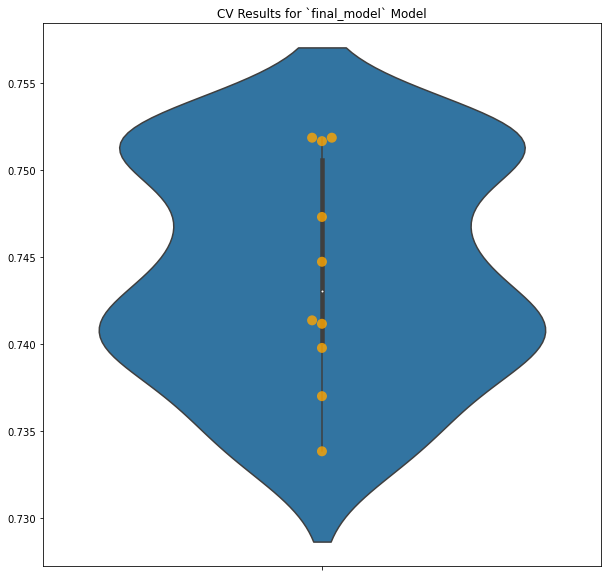

In [738]:
final_model_check = ModelWithCV(
    final_model,
    model_name='final_model',
    X=X_train_both,
    y=y_train_both)
fig, ax = plt.subplots(figsize=(10,10))

final_model_check.plot_cv(ax=ax);

In [739]:
final_model_check.print_cv_summary()

CV Results for `final_model` model:
            0.74403 ± 0.00615 accuracy
        


In [740]:
# Score against hold out

final_model.score(X_test_both, y_test_both)

0.7460157126823793

In [741]:
y_pred = final_model.predict(X_test_both)

In [742]:
print(classification_report(y_test_both, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      4843
           1       0.74      0.69      0.71      4067

    accuracy                           0.75      8910
   macro avg       0.74      0.74      0.74      8910
weighted avg       0.75      0.75      0.75      8910



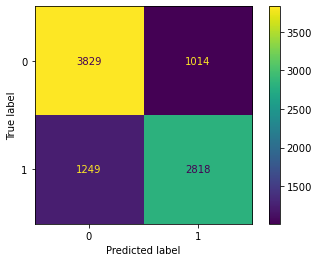

In [743]:
plot_confusion_matrix(final_model, X_test_both, y_test_both);

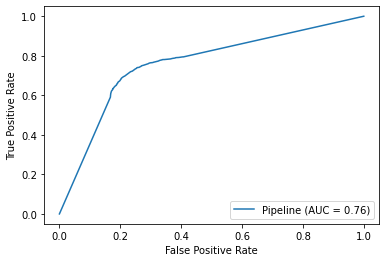

In [744]:
plot_roc_curve(base_dtc_pipe, X_test_both, y_test_both)

## Analysis

### Finding Important Features

In [745]:
importance = final_model._final_estimator.feature_importances_
# # summarize feature importance
for i,v in enumerate(importance):
     if v > 0.05:
        print('Feature: %0d, Score: %.5f' % (i, v))

Feature: 0, Score: 0.20015
Feature: 1, Score: 0.09889
Feature: 1937, Score: 0.09941


In [746]:
for name, importance in zip(X_train_both.columns, importance):
    print(name, importance)

gps_height 0.20014732034244131
installer 0.09888798586760565
basin 4.192571580449594e-05
region_code 0.00015305766791458866
population 4.9026046707261046e-05
public_meeting 0.00012357172251566633
scheme_management 6.225968796967625e-05
permit 0.0
construction_year 0.0
extraction_type_class 0.0
management_group 0.0
payment_type 0.0
quality_group 0.0
source_type 0.0
waterpoint_type 0.0


### GPS Height

In [747]:
df_copy.groupby('status_group')['gps_height'].agg(['max', 'min','mean', 'median', 'count'])

,max,min,mean,median,count
status_group,,,,,
functional,2628,-90,740.131188,550,32259
non functional,2770,-59,582.917505,302,27141


### Installer

In [748]:
df_copy.status_group.value_counts()

functional        32259
non functional    27141
Name: status_group, dtype: int64

In [749]:
# I need to change the status_group to the binary y variable I created
df_copy.status_group = y

In [750]:
installers = df_copy.installer.value_counts()
big_installers = installers[installers>99].index
big_installers = list(big_installers)

In [751]:
filtered_installers = df_copy[df_copy['installer'].isin(big_installers)]

In [752]:
# most error prone installers
filtered_installers.groupby('installer')['status_group'].mean().sort_values(ascending=False).head(10)

installer
fw                               0.924855
district water department        0.898204
fini water                       0.871465
centr                            0.870370
central govt                     0.833333
finw                             0.817308
halmashauri ya wilaya sikonge    0.784314
rwe                              0.747927
lga                              0.745763
hsw                              0.720000
Name: status_group, dtype: float64

In [753]:
# least error prone installers
filtered_installers.groupby('installer')['status_group'].mean().sort_values().head(10)

installer
acra                    0.021583
magadini-makiwaru wa    0.022857
lawatefuka water sup    0.066667
dmdd                    0.087766
twe                     0.108108
ces                     0.118033
rc                      0.124294
wu                      0.132890
village council         0.153846
wananchi                0.185430
Name: status_group, dtype: float64

### Region

In [754]:
# most error prone regions
df_copy.groupby('region')['status_group'].agg(['mean', 'count', 'sum']).sort_values(by='mean', ascending=False).head(10)

,mean,count,sum
region,,,
Lindi,0.702458,1546,1086
Mtwara,0.697110,1730,1206
Rukwa,0.608960,1808,1101
Tabora,0.567126,1959,1111
Mara,0.550025,1969,1083
Dodoma,0.541572,2201,1192
Singida,0.516961,2093,1082
Kigoma,0.515980,2816,1453
Mwanza,0.515796,3102,1600


In [755]:
# least error prone regions
df_copy.groupby('region')['status_group'].agg(['mean', 'count', 'sum']).sort_values(by='mean').head(10)

,mean,count,sum
region,,,
Iringa,0.217794,5294,1153
Arusha,0.315224,3350,1056
Manyara,0.376500,1583,596
Kilimanjaro,0.397123,4379,1739
Pwani,0.409488,2635,1079
Dar es Salaam,0.427329,805,344
Tanga,0.436199,2547,1111
Ruvuma,0.439394,2640,1160
Shinyanga,0.440185,4982,2193


I want to take a look at the Lindi region, because there has been a lot of waterpoints that need repair in that region. I'm curious as to which waterpoint_type had the least amount of waterpoints needing repair in the Lindi region.

In [756]:
lindi = df_copy.loc[(df_copy['region_code']==8)]
lindi.groupby('waterpoint_type')['status_group'].agg(['mean', 'count', 'sum']).sort_values(by='mean')

,mean,count,sum
waterpoint_type,,,
hand pump,0.653061,49,32
communal standpipe multiple,0.960000,100,96
other,0.965812,117,113
communal standpipe,0.970588,34,33


## Production Model

In [757]:
final_model.fit(X,y)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_numerics',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['gps_height', 'population'], dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(hand